In [2]:
# THIS SOLVER USES THE GUROBI OPTIMIZATION SOFTWARE

from gurobipy import *

import shapely
import math
import pyproj
import sys
import fiona
import traceback
import json
sys.path.append('../../../alg')

import matplotlib.pyplot as plt, pandas as pd, geopandas as gpd, numpy as np
import distance_buffer as db, border_generators as bg, marching_army as ma, census_parser as cp, cmclp_solver as solver, data_generator as datagen, result_analyzer as ra

from rtree import index
from matplotlib import pyplot
from functools import partial
from shapely import geometry
from shapely.ops import transform
from descartes import PolygonPatch
from matplotlib.patches import Arc
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
from scipy.stats import truncnorm

In [3]:
reload(ra)

<module 'result_analyzer' from '../../../alg/result_analyzer.pyc'>

# Read in / filter the data

In [2]:
bg_data_str = "../../../data/CA_WalnutCreek/CA_pop_bg/tabblock2010_06_pophu.shp"
places_data_str = "../../../data/CA_WalnutCreek/CA_places/tl_2010_06_place10.shp"
faces_data_str = "../../../data/CA_WalnutCreek/CTY_faces/tl_2010_06013_faces.shp"
countycode = '013'
placename = "Walnut Creek"

In [3]:
%%time
data = cp.get_place_blockgroup_data(bg_data_str, places_data_str,
                                       faces_data_str, countycode, placename)

CPU times: user 1min 56s, sys: 2.51 s, total: 1min 59s
Wall time: 1min 58s


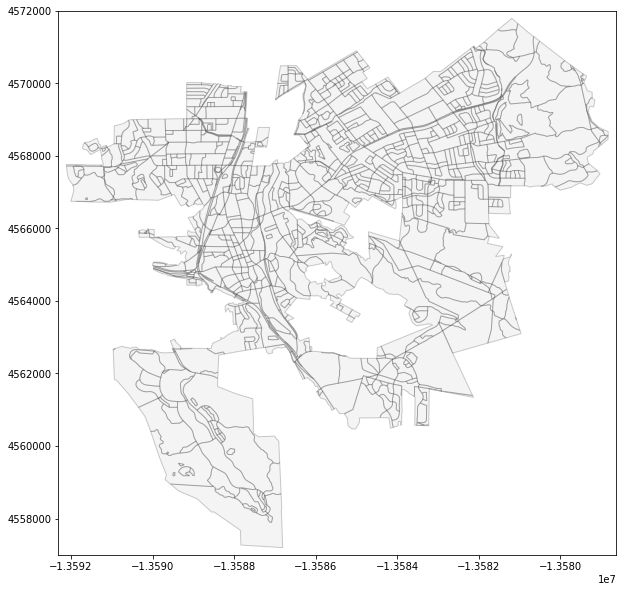

In [4]:
west,south,east,north = data['place_geom'].bounds
fig1, ax1 = plt.subplots(figsize=(10,10))
for polygon in data['place_geom']:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.2, zorder=0)
    ax1.add_patch(patch)
ax1.set_xlim(west-200, east+200)
ax1.set_ylim(south-200, north+200)
ax1.axis('on')
#plt.savefig("grid_candpts_w_randpts_fixed.png",  dpi=192 * 10)
plt.show()

# Experiment outline
- Key: $X_m$ = mclp ; $ X_c$ = cmclp ; $l =$ some integer; other variables following from model
- Trials: 100 of each

- try with different formations (of potl facility locations)
- try with different 

## Experiment 1 - Varying population distribution about the BG's


### Experiment 1a - w/ demand sites random, potl facility sites triangular
- Set  $  S_m = S_c ;\;\; P_m = P_c ;\;\; a_m = a_c = \{A_1, A_2,...A_q\}, \;\; A_q = \{a_1,a_2,...,a_i\}; \;\;\; I_m = I_c;\;\; J_m = J_c $

#### _Generate the data_

In [9]:
# generate the 1 set of demand sites

num_trials_1a = 100


desired_num_demand_pts = 7000
xrands_1a, yrands_1a = datagen.gen_n_random_coords([west,south,east,north], desired_num_demand_pts*3)
rnd_demand_pts_1a = datagen.filter_random_pts_by_RoI(xrands_1a,yrands_1a,data['place_geom'],data['place_pop_data'])

# gen 100 different weight distributions dmd pts
dmd_wts_1a = []
for i in range(0,num_trials_1a):
    tmp_wt_1a = datagen.assign_pops_to_pts(rnd_demand_pts_1a, data['place_pop_data'])
    datagen.test_pop_pt_agreement(data['place_pop_data'], tmp_wt_1a, rnd_demand_pts_1a) #should change this 
                                                    #from outputting something to something that returns val
    dmd_wts_1a.append(tmp_wt_1a)


In [35]:
# flatten the wts 
dmd_wts_1a_flat = []
for i in range(0,len(dmd_wts_1a)):
    tmp = []
    for j in range(0,len(dmd_wts_1a[i])):
        for k in range(0,len(dmd_wts_1a[i][j])):
            tmp.append(dmd_wts_1a[i][j][k])
    dmd_wts_1a_flat.append(tmp)
            

In [16]:
# flatten the dmd pts
rnd_demand_pts_1a_flat = datagen.list_of_gdf_to_list_of_coords(rnd_demand_pts_1a)

In [12]:
# generate the facility sites
S_1a = 250.0
tri_fac_pts_1a = datagen.gen_triangular_gridpts([west,south,east,north],S_1a)

In [46]:
len(rnd_demand_pts_1a_flat)

6734

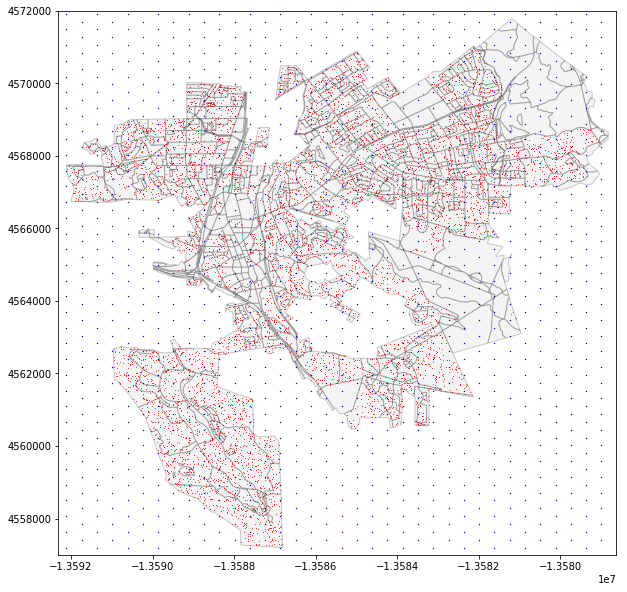

In [13]:
west,south,east,north = data['place_geom'].bounds
fig1, ax1 = plt.subplots(figsize=(10,10))
for polygon in data['place_geom']:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.2, zorder=0)
    ax1.add_patch(patch)
ax1.scatter(x=tri_fac_pts_1a['x'], y=tri_fac_pts_1a['y'], s=2, c='b', linewidth=0, zorder=3)

for gdf in rnd_demand_pts_1a:
    if len(gdf)>0:
        ax1.scatter(x=gdf['x'], y=gdf['y'], s=1, c='r', linewidth=0, zorder=3)
    #447
#1915

ax1.set_xlim(west-200, east+200)
ax1.set_ylim(south-200, north+200)
ax1.axis('on')
plt.show()

In [61]:
# set P to 50
P_1a = 50

In [70]:
%%time
#write to an outfile
exp_1a_outfile_m = open('experiment_1a_results_m.json','w')
exp_1a_outfile_c = open('experiment_1a_results_mc.json','w')

m_1a_output = []
c_1a_output = []
cnt_c = 0
cnt_m = 0
try:
    # run mclp trials
    for i in range(0,len(dmd_wts_1a_flat)):
        tmpm = mclp_stages_elim(rnd_demand_pts_1a_flat,dmd_wts_1a_flat[i],tri_fac_pts_1a_flat,P_1a,S_1a,stopcond=2)
        json.dump(tmpm, exp_1a_outfile_m)
        m_1a_output.append(tmpm)
        cnt_m += 1
        
    # run cmclp trials 
    for i in range(0,len(dmd_wts_1a_flat)):
        tmpc = cmclp_stages_elim(rnd_demand_pts_1a_flat,dmd_wts_1a_flat[i],tri_fac_pts_1a_flat,P_1a,S_1a,stopcond=2,relgaptol=0.000)
        json.dump(tmpc, exp_1a_outfile_c)
        c_1a_output.append(tmpc)
        cnt_c += 1
        
except:
    traceback.print_exc()
finally:
    exp_1a_outfile_m.close()
    exp_1a_outfile_c.close()
    print cnt_c
    print cnt_m


100
100
CPU times: user 3h 5min 28s, sys: 1min 53s, total: 3h 7min 22s
Wall time: 3h 7min 17s


In [6]:
#get the json data 
exp_1a_datafile_c = open('experiment_1a_results_mc.json','r')

exp_1a_data_c = json.load(exp_1a_datafile_c)

ValueError: Extra data: line 1 column 48634 - line 1 column 4863271 (char 48633 - 4863270)

[{'coveredpop': 27885,
  'coveredpts': [1993,
   1998,
   1999,
   2001,
   2003,
   2004,
   2006,
   2007,
   2010,
   4377,
   4378,
   4379,
   4381,
   4382,
   4383,
   4385,
   4386,
   4388,
   4389,
   4390,
   4391,
   4392,
   4393,
   4394,
   4395,
   4396,
   4397,
   4398,
   489,
   490,
   2053,
   2054,
   2055,
   2056,
   2057,
   2058,
   2059,
   2060,
   3931,
   3932,
   3933,
   3936,
   3937,
   3938,
   3942,
   3944,
   3945,
   3957,
   4006,
   4007,
   4008,
   4009,
   4010,
   4011,
   4012,
   4013,
   4014,
   4015,
   4016,
   5654,
   4368,
   4534,
   4535,
   4536,
   5429,
   5430,
   5431,
   5432,
   5433,
   5434,
   5435,
   5436,
   5437,
   5438,
   5441,
   5468,
   5469,
   6123,
   6124,
   6125,
   6126,
   6127,
   6128,
   820,
   821,
   822,
   823,
   824,
   825,
   829,
   836,
   841,
   842,
   4072,
   4073,
   4168,
   4169,
   4170,
   4171,
   6013,
   6015,
   359,
   360,
   364,
   365,
   368,
   370,
   372,
   784,
  

### Experiment 1b - w/ demand sites = potl facility sites
- Set $  S_m = S_c ;\;\; P_m = P_c ;\;\; a_m = a_c = \{A_1,A_2,...,A_q\},\;\; A_q = \{a_1,a_2,...a_q\};\;\; I_m = I_c = \{I_1,I_2,...,I_q\} = J_m = J_c = \{J_1,J_2,...,J_q\}$

### ??? Experiment 1c - w/ $ a_q $'s equal for each $q$
- Set  $  S_m = S_c ;\;\; P_m = P_c ;\;\; a_m = a_c = \{A_1,A_2,...,A_q\},\;\; A_1 = l_1,\;\;A_2=l_2,\;\;A_q=l_q ;\;\; I_m = I_c = \{I_1,I_2,...,I_q\};\;\; J_m = J_c $

## Experiment 2 - Varying the coverage distance S

### Experiment 2a - w/ demand sites random, potl facility sites triangular
- Set $  S_m = S_c = \{S_1,S_2...S_{100}\};\;\; P_m = P_c ;\;\; a_m = a_c ;\;\; I_m = I_c ;\;\; J_m = J_c $


### Experiment 2b - w/ demand sites = potl facility sites
- Set $  S_m = S_c = \{S_1,S_2...S_{100}\};\;\; P_m = P_c ;\;\; a_m = a_c ;\;\; I_m = I_c = J_m = J_c $

# Methods

In [57]:
def cmclp_stages_elim(demandpts, demandwts, facilitypts, stageP, stageS, stopcond=2, disttol=0.0, objparams={"index": [0,1], "priority":[0,0], "weight":[1.,1.],
                      "abstol":[0.,0.], "reltol":[0.,0.]}, relgaptol=0.0004):
    # TODO: find out  - how do we get the chosen sites from the nonopt solns?
    #       (i.e. X # solns found...) - also, do we care? (why would we?)

    curdemandpts = demandpts
    curdemandwts = demandwts
    curpotlsites = facilitypts
    curnumdemandpts = len(curdemandpts)
    pt_wt_dict = todict(curdemandpts, curdemandwts)

    P = stageP
    S = stageS
    objectiveparams = objparams

    # {"sites":, "coveredpts":, "coveredpop":, "output":, "coverror":}
    stagesolns = []

    # TESTING PURPOSES
    #k = 0
    #cnt # times we've had the same # demand pts; stop after STOP
    repeatdemandptcnt = 0
    stop = stopcond
    tol = disttol

    while (repeatdemandptcnt < stop):
       # print "dmd "+str(len(curdemandpts))
       # print "sites "+str(len(curpotlsites))
        cur_N = solver.generate_set_N(curdemandpts, curpotlsites, S, tol)

        cursoln, curstatus = solver.cmclp_solve(curpotlsites, curdemandpts, curdemandwts, cur_N, P, S, objectiveparams, relgaptol)
        #return the ACTUAL covered demand pts and the ACTUAL covered pop
        curcoveredpts, coveringsites, curcoveredpop = solver.actual_coverage(cursoln, cur_N, curdemandwts)
        #these are the demand pts NOT covered by the soln

        coverage_error = list(set(cursoln)-set(curcoveredpts))

        # we will use the the ACTUALLY covered pts, get those coords
        tmp_demandpts = []
        for ind in curcoveredpts:
            tmp_demandpts.append(curdemandpts[ind])

        nextdemandpts = list(set(curdemandpts)-set(tmp_demandpts))

        nextdemandwts = []
        for pt in nextdemandpts:
            nextdemandwts.append(pt_wt_dict[pt])

       # print "covering sites "+str(len(coveringsites))
        # eliminate used up facility sites
        nextpotlpts = []
        for i in range(0,len(curpotlsites)):
            if i not in coveringsites:
                nextpotlpts.append(curpotlsites[i])
       # print "nextsites "+str(len(nextpotlpts))

        stagesolns.append({"sites":cursoln, "coveredpts":curcoveredpts, "coveringsites": coveringsites,
                           "coveredpop":curcoveredpop, "output":curstatus, "coverror":coverage_error})

        if len(curdemandpts) == len(nextdemandpts):
            repeatdemandptcnt += 1
        else:
            repeatdemandptcnt = 0

        curdemandwts = nextdemandwts
        curdemandpts = nextdemandpts
        curpotlsites = nextpotlpts

    return stagesolns


In [58]:
def mclp_stages_elim(demandpts, demandwts, facilitypts, stageP, stageS, stopcond=2, disttol=0.0):
    curdemandpts = demandpts
    curdemandwts = demandwts
    curpotlsites = facilitypts
    curnumdemandpts = len(curdemandpts)
    pt_wt_dict = todict(curdemandpts, curdemandwts)

    P = stageP
    S = stageS

    # {"sites":, "coveredpts":, "coveredpop":, "output":, "coverror":}
    stagesolns = []

    #cnt # times we've had the same # demand pts; stop after STOP
    repeatdemandptcnt = 0
    stop = stopcond
    tol = disttol

    while (repeatdemandptcnt < stop):
    
        cur_N = solver.generate_set_N(curdemandpts, curpotlsites, S, tol)
        cursoln, curstatus = solver.mclp_solve(curpotlsites, curdemandpts, curdemandwts, cur_N, P, S)

        #return the ACTUAL covered demand pts and the ACTUAL covered pop
        curcoveredpts, coveringsites, curcoveredpop = solver.actual_coverage(cursoln, cur_N, curdemandwts)
        #these are the demand pts NOT covered by the soln
        coverage_error = list(set(cursoln)-set(curcoveredpts))

        # we will use the the ACTUALLY covered pts, get those coords
        tmp_demandpts = []
        for ind in curcoveredpts:
            tmp_demandpts.append(curdemandpts[ind])        

        nextdemandpts = list(set(curdemandpts)-set(tmp_demandpts))
        # print "num covered pts "+str(len(curcoveredpts))
        # print "num covered coords "+str(len(tmp_demandpts))
        # print "num next dmd pts "+str(len(nextdemandpts))


        nextdemandwts = []
        for pt in nextdemandpts:
            nextdemandwts.append(pt_wt_dict[pt])
            
        nextpotlpts = []
        for i in range(0,len(curpotlsites)):
            if i not in coveringsites:
                nextpotlpts.append(curpotlsites[i])

        stagesolns.append({"sites":cursoln, "coveredpts":curcoveredpts, "coveringsites": coveringsites,
                           "coveredpop":curcoveredpop, "output":curstatus, "coverror":coverage_error})

        if len(curdemandpts) == len(nextdemandpts):
            repeatdemandptcnt += 1
        else:
            repeatdemandptcnt = 0

        curdemandwts = nextdemandwts
        curdemandpts = nextdemandpts
        curpotlsites = nextpotlpts 

    return stagesolns

In [21]:
#first arg [list] will be key, second arg [list] will be val
def todict(keys, vals):
    return dict(zip(keys,vals))